# Bibliotecas importadas

In [1]:
import glob
import os
from glob import glob
from os import rename
#import PyPDF2
from tika import parser
import re
import pandas as pd
import numpy as np
import nltk
import time
import requests

from nltk import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn import preprocessing

import spacy
import en_core_web_sm

from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
import pickle

from sklearn.decomposition import LatentDirichletAllocation

from pprint import pprint
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

C:\Users\X510UR\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Variables

In [2]:
path_ia = "./RepositorioArticulosAcademicos/Artificial_intelligence/"
path_nsc = "./RepositorioArticulosAcademicos/Networks_and_Security_in_Computation/"
path_sc = "./RepositorioArticulosAcademicos/Scientific_Computing/"
path_sive = "./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/"
path_sedb = "./RepositorioArticulosAcademicos/Software_engineering_and_databases/"
path_tc = "./RepositorioArticulosAcademicos/Theory_of_computing/"

ia_pdf = glob(path_ia + '*.pdf')
nsc_pdf = glob(path_nsc + '*.pdf')
sc_pdf = glob(path_sc + '*.pdf')
sive_pdf = glob(path_sive + '*.pdf')
sedb_pdf = glob(path_sedb + '*.pdf')
tc_pdf = glob(path_tc + '*.pdf')
print('Cantidad de artículos: ', 
      len(ia_pdf)+len(nsc_pdf)+len(sc_pdf)+len(sive_pdf)+len(sedb_pdf)+len(tc_pdf))
articulos = [ia_pdf, nsc_pdf, sc_pdf, sive_pdf, sedb_pdf, tc_pdf]

stop_words = set(nltk.corpus.stopwords.words("english"))
pattern_punctuation = '(?:[.,\/!$%?¿?!¡\^&\*;:{}=><\-_`~()”“"\|])'

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

<input>:19: DeprecationWarning: invalid escape sequence \/
<input>:19: DeprecationWarning: invalid escape sequence \/
<input>:19: DeprecationWarning: invalid escape sequence \/
<ipython-input-2-23619da812e4>:19: DeprecationWarning: invalid escape sequence \/
  pattern_punctuation = '(?:[.,\/!$%?¿?!¡\^&\*;:{}=><\-_`~()”“"\|])'


Cantidad de artículos:  272


# Metodología Kappa Cohen

In [9]:
# https://stackoverflow.com/questions/11528150/inter-rater-agreement-in-python-cohens-kappa
from nltk import agreement
from statistics import mode

def metodology():
    #d = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
    #r1 = [8, 7, 8, 6, 2, 5, 3, 6, 6, 4, 2, 1, 0, 2, 2, 3, 6, 3]
    #r2 = [3, 2, 3, 3, 2, 2, 4, 6, 3, 8, 7, 8, 6, 2, 5, 3, 6, 6]
    #r3 = [4, 2, 1, 0, 2, 2, 3, 6, 3, 3, 2, 3, 3, 2, 2, 4, 6, 3]
    
    archivo_excel = pd.read_excel('observaciones.xlsx')
    d = archivo_excel['nombre_artículo'].values
    r1 = archivo_excel['etiqueta_Luis'].values
    r2 = archivo_excel['etiqueta_Pilar'].values
    r3 = archivo_excel['etiqueta_Fer'].values
    
    k = k_kappa(r1, r2, r3)
    print(k)
    lista_doc_a_eliminar = []
    i = 0
    f = len(d)
    while i < f:
        if (r1[i]!=r2[i] and r2[i]!=r3[i] and r1[i]!=r3[i]):
            r1 = np.delete(r1,i)
            r2 = np.delete(r2,i)
            r3 = np.delete(r3,i)
            lista_doc_a_eliminar.append(d[i])
            d = np.delete(d,i)                
            f -= 1
        else:
            i +=1    
    k = k_kappa(r1, r2, r3)
    print(k)
    
    x = []
    j = 0
    f = len(d)
    while j < f:
        # https://es.stackoverflow.com/questions/151572/como-hallar-el-numero-mas-repetido-de-una-lista
        m = mode([r1[j], r2[j], r3[j]])
        if (m==6):
            r1 = np.delete(r1,j)
            r2 = np.delete(r2,j)
            r3 = np.delete(r3,j)
            lista_doc_a_eliminar.append(d[j])
            d = np.delete(d,j)                
            f -= 1
        else:
            x.append(m)
            destino = cases_abrev_move(m)
            name = d[j]
            mover_archivo(name, destino)
            j +=1
    k = k_kappa(r1, r2, r3)
    print(k)
    
    est_d = dict()
    for item in x:
        try:
            est_d[item]+=1
        except KeyError:
            est_d[item]=1
    print("Stadistic: ", est_d)
    print(lista_doc_a_eliminar)
    return k, r1, r2, r3, d, x

#http://www.nltk.org/api/nltk.metrics.html
#leer  https://www.medcalc.org/manual/inter-rater_agreement.php
def k_kappa(r1, r2, r3):
    taskdata=[[0,str(i),str(r1[i])]  
              for i in range(0,len(r1))]+[[1,str(i),str(r2[i])] 
                                          for i in range(0,len(r2))]+[[2,str(i),str(r3[i])] 
                                                                      for i in range(0,len(r3))]
    ratingtask = agreement.AnnotationTask(data=taskdata)
    kappa=ratingtask.kappa()
    return kappa


def cases_abrev_move(x):
    return {
        '0': './RepositorioArticulosAcademicos/Artificial_intelligence/',
        '1': './RepositorioArticulosAcademicos/Networks_and_Security_in_Computation/',
        '2': './RepositorioArticulosAcademicos/Scientific_Computing/',
        '3': './RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/',
        '4': './RepositorioArticulosAcademicos/Software_engineering_and_databases/',
        '5': './RepositorioArticulosAcademicos/Theory_of_computing/',
    }[str(x)]

import shutil, os

def mover_archivo(name, destino):
    origen = './RepositorioArticulosAcademicos/' + name
    if os.path.exists(origen):  
        ruta = shutil.move(origen, destino)
        print('El directorio ha sido movido a', destino)
    else:
        print('El directorio origen no existe')
    return
    

#k, r1, r2, r3, d, x = metodology()
#print(len(x))

0.7844805594842647
0.799371614647805
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificial_intelligence/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Artificia

El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAcademicos/Signals_Images_and_Virtual_Environments/
El directorio ha sido movido a ./RepositorioArticulosAc

# Cambiar nombre a los documentos

In [20]:
def change_namePDF():    
    path = [path_ia, path_nsc, path_sc, path_sive, path_sedb, path_tc]
    cont=1
    for i in range(len(path)):
        for filename in os.listdir(path[i]):  
            dst = "art" + str(cont) + "_" + cases_abrev(i) + ".pdf"
            src = path[i] + filename 
            dst = path[i] + dst 
            # rename() function will -- rename all the files 
            os.rename(src, dst) 
            cont += 1
    return "archivos cambiados de nombre"
        
def cases_abrev(x):
    return {
        '0': 'AI',
        '1': 'NSC',
        '2': 'SC',
        '3': 'SIVE',
        '4': 'SEDB',
        '5': 'TC',
    }[str(x)]

#change_namePDF()

# Carga de los documentos

In [14]:
def save_pdf_2_txt():
    cont = 0
    for i in range(len(articulos)):
        for j in range(len(articulos[i])):    
            path = articulos[i][j]
            texto = read_pdf_file(path)
            spath = path.split("\\")
            nfile = spath[1].split(".")
            if j == 0:
                if os.path.isdir(spath[0] + '/text') == False:
                    #os.mkdir(spath[0] + '/text')
                    os.makedirs(spath[0] + '/text')
            with open(spath[0] + '/text/' + nfile[0] + '.txt', "wb") as f:
                f.write(texto.encode("utf-8"))                
                f.close()
            cont += 1
    print("He procesado todos los PDF a TXT. Total: ", cont)
    return
    
def read_pdf_file(filename):       
    raw = parser.from_file(filename)
    text = " ".join(raw['content'].strip().split('\n'))  
    text = re.sub(r" +", " ", re.sub(r"\t", " ", re.sub(r"\n+", " ", text)))
    return str(text)

#save_pdf_2_txt()

He procesado todos los PDF a TXT. Total:  272


### eliminar todos los archivos txt

In [17]:
def delete_txt_file(folder):
    
    path = [glob(path_ia+folder+'*.txt'), glob(path_nsc+folder+'*.txt'), glob(path_sc+folder+'*.txt'),
            glob(path_sive+folder+'*.txt'), glob(path_sedb+folder+'*.txt'), glob(path_tc+folder+'*.txt')]
    for i in range(len(path)):
        for j in range(len(path[i])):
            p = re.sub(r"\\", "/", path[i][j])
            os.remove(p) 
    
    #eliminar la carpeta
    #   os.rmdir("Libros")
    #   os.removedirs("Musica/Pop/2014")
    #para eliminar una carpeta con archivos 
    #   shutil.rmtree("mp3")
    '''        
    import shutil
    path = [path_ia+folder, path_nsc+folder, path_sc+folder, path_sive+folder, path_sedb+folder, path_tc+folder]
    for i in range(len(path)):        
        shutil.rmtree(path[i])
    '''
    return print("eliminado todos los archivos txt")

#folder = 'text/' 
#folder = 'abstract/'
#folder = 'keywords/'
#delete_txt_file(folder)

### guardando a excel el etiquetado

In [18]:
def save_excel():
    name_art = []
    label = []
    
    for i in range(len(articulos)):
        art = []
        ext = ""
        for j in range(len(articulos[i])):
            path = articulos[i][j]
            spath = path.split("\\")
            nfile = spath[1].split("_")  
            num = nfile[0].split("art")
            art.append(int(num[1]))
            label.append(i)
            ext = nfile[1]
        art.sort()
        for j in art:
            name_art.append("art"+str(j)+"_"+ext)
    
    data = {'nombre_artículo': name_art,
            'etiqueta_Luis': label}
    df = pd.DataFrame(data, columns = ['nombre_artículo', 'etiqueta_Luis'])
    df.to_excel('observaciones.xlsx', sheet_name='example')
    return print("excel generado")

#save_excel()

excel generado


# Extracts the abstract and keywords

In [4]:
def unicodetoascii(text):
    
    TEXT = (text.
            replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').#
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")").
            replace('xef\\\\x80\\\\xad\\\\xef\\\\x80\\\\xad', "-").
            replace('\\\\xef\\\\x80\\\\xad\\\\xef\\\\x80\\\\xad', "-").
            replace('\\\\xef\\\\xbf\\\\xbd', "-").
            replace('\\\\xef\\\\x81\\\\xb5', "-").
            replace('\\\\xcf\\\\x87', "-").
            replace('\\\\xef\\\\x80\\\\xa0', "-").
            replace('\\\\xe2\\\\x88\\\\x97', "-")
           )
    return TEXT

LATIN_1_CHARS = (
    ('\xe2\x80\x99', "'"),
    ('\xc3\xa9', 'e'),
    ('\xe2\x80\x90', '-'),
    ('\xe2\x80\x91', '-'),
    ('\xe2\x80\x92', '-'),
    ('\xe2\x80\x93', '-'),
    ('\xe2\x80\x94', '-'),
    ('\xe2\x80\x94', '-'),
    ('\xe2\x80\x98', "'"),
    ('\xe2\x80\x9b', "'"),
    ('\xe2\x80\x9c', '"'),
    ('\xe2\x80\x9c', '"'),
    ('\xe2\x80\x9d', '"'),
    ('\xe2\x80\x9e', '"'),
    ('\xe2\x80\x9f', '"'),
    ('\xe2\x80\xa6', '...'),
    ('\xe2\x80\xb2', "'"),
    ('\xe2\x80\xb3', "'"),
    ('\xe2\x80\xb4', "'"),
    ('\xe2\x80\xb5', "'"),
    ('\xe2\x80\xb6', "'"),
    ('\xe2\x80\xb7', "'"),
    ('\xe2\x81\xba', "+"),
    ('\xe2\x81\xbb', "-"),
    ('\xe2\x81\xbc', "="),
    ('\xe2\x81\xbd', "("),
    ('\xe2\x81\xbe', ")")
)

def clean_latin1(data):
    try:
        return data.encode('utf-8')
    except UnicodeDecodeError:
        data = data.decode('iso-8859-1')
        for _hex, _char in LATIN_1_CHARS:
            data = data.replace(_hex, _char)
        return data.encode('utf8')
    
#http://web.mit.edu/ecprice/python/beautifulsoup4-4.1.0-py2.6.egg/bs4/dammit.py
#tengo que ver esta implementación, creo que reemplaza todo tipo de caracteres UNICODE
#https://www.utf8-chartable.de/unicode-utf8-table.pl?start=8192&number=128&utf8=string-literal
#http://www.ccp4.ac.uk/dist/checkout/Python-2.7.10/Lib/test/test_unicode.py

def clean_text_ts(text):
    unwanted_char = '\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f\x7f\x80\x81\x82\x83\x84\x85\x86\x87\x88\x89\x8a\x8b\x8c\x8d\x8e\x8f\x90\x91\x92\x93\x94\x95\x96\x97\x98\x99\x9a\x9b\x9c\x9d\x9e\x9f\xa0\xa1\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xab\xac\xad\xae\xaf\xb0\xb1\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xbb\xbc\xbd\xbe\xbf\xc0\xc1\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xcb\xcc\xcd\xce\xcf\xd0\xd1\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xdb\xdc\xdd\xde\xdf\xe0\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xeb\xec\xed\xee\xef\xf0\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xfb\xfc\xfd\xfe\xff'
    text = "".join([(" " if n in unwanted_char else n) for n in text if n not in unwanted_char])
    return text

In [21]:
def extract_abstract_keywords():
    pattern1 = r'(?:abstract|summary)'
    pattern2 = r'(?:résumé|resumen|key word[s]?|keyword[s]?|index term[s]?|key_word[s]?|key-word[s]?)'
    pattern3 = r'(?:[\w\W\s\S]*)'
    pattern4 = r'(?:key word[s]?|keyword[s]?|index term[s]?|key_word[s]?|key-word[s]?)'  
    pattern5 = r'(?:[\W]?[\s]*resumen|[\W]?[\s]*[1|i|a]?[.|_|-|\s]+introduct[ion]?|[\W]?[\s]*(?:(?:20)\d\d)[\s]*[ams|mathematics subject])'
    pattern6 = r'(?:[\W]*)' 
    pattern7 = r'(?:ams|mathematics subject|paper|fecha|received|handling editor|some figures|article type|running head|pacs|address all correspondence|corresponding author|contacts|chinese library classification|address for correspondence|correspondence|mailto)'
    pattern8 = r'(?:[,|;])'
    pattern9 = r'(?:^(b\'|b"))'
    pattern10 = r'(?:$(i.|1.))'
        
    path = [glob(path_ia+'text/*.txt'), glob(path_nsc+'text/*.txt'), glob(path_sc+'text/*.txt'),
            glob(path_sive+'text/*.txt'), glob(path_sedb+'text/*.txt'), glob(path_tc+'text/*.txt')]   
    
    for i in range(len(path)):
        pal = ''
        for j in range(len(path[i])):
            p = re.sub(r"\\", "/", path[i][j])
            
            with open(p, 'r', encoding='utf8') as file:
                text = file.read().encode('utf-8')
                file.close()
            text = str(text).lower()
            
            abstract = re.findall(pattern1+pattern3+pattern2,text)
            abstract = [re.sub(pattern2+pattern3, "", t) for t in abstract]
            
            keywords = re.findall(pattern4+pattern3+pattern5,text)           
            
            '''
            keywords = [unicodetoascii(t).strip() for t in keywords] 
            keywords = [clean_latin1(t).strip() for t in keywords]
            #keywords = [clean_text_ts(str(t)) for t in keywords]
            keywords = [re.sub(pattern5+pattern3, "", str(t)) for t in keywords]   
            keywords = [re.sub(pattern4+pattern6, "", t) for t in keywords]
            keywords = [re.sub(pattern7+pattern3, "", t) for t in keywords]
            keywords = [re.sub(pattern8, "\n", t) for t in keywords]
            keywords = [t.split('\n') for t in keywords]        
            '''
                
            texto = ''
            for k in keywords:
                texto += k
        
            texto = unicodetoascii(texto).strip()
            texto = clean_latin1(texto).strip()
            texto= str(texto)
            #print(type(texto))
            texto = re.sub(pattern5+pattern3, "", texto)
            texto = re.sub(pattern4+pattern6, "", texto)
            texto = re.sub(pattern7+pattern3, "", texto)
            texto = re.sub(pattern9, "", texto)
        
            nfile = p.split("text/art")
                        
            if j == 0:
                if os.path.isdir(nfile[0] + '/abstract') == False:
                    os.makedirs(nfile[0] + '/abstract')
                if os.path.isdir(nfile[0] + '/keywords') == False:
                    os.makedirs(nfile[0] + '/keywords')
            
            with open(nfile[0]+'abstract/abstract'+nfile[1], "wb") as f:
                for t in abstract:
                    f.write(t.encode("utf-8")) 
                    f.close()
                
            '''
            with open(nfile[0]+'keywords/keywords'+nfile[1], "wb") as f:
                for t in keywords:
                    f.write(t.encode("utf-8")) 
                f.close()
            '''          
      
            with open(nfile[0]+'keywords/keywords'+nfile[1], "wb") as f:
                f.write(texto.encode("utf-8")) 
                f.close()
            
            texto = re.sub(pattern8, "\n", texto)
            keywords = texto.split('\n')
            keywords = [t.strip() for t in keywords]
            
            for t in keywords:
                pal += t + ' '
            '''
            for t in keywords:
                pal += t + '\n'
            '''
                
        with open(nfile[0]+'keywords_'+cases_abrev(i)+'.txt', "wb") as f:
            f.write(pal.encode("utf-8")) 
            f.close()
            
    return print("Todos los abstract y keywords extraídos y guardados txt")

#extract_abstract_keywords()

Todos los abstract y keywords extraídos y guardados txt


# Carga corpus (train & test)

In [3]:
def read_txt_files(files):
    files_list=[]
    for i,file_path in enumerate(files):
        with open(file_path, 'r', encoding='utf8') as infile:
            files_list.append(infile.read().encode('utf-8'))
    return files_list

def carga_corpus(folder):
    #leemos el corpu
    ia_txt = read_txt_files(glob(path_ia + folder + '*.txt'))
    nsc_txt = read_txt_files(glob(path_nsc + folder + '*.txt'))
    sc_txt = read_txt_files(glob(path_sc + folder + '*.txt'))
    sive_txt = read_txt_files(glob(path_sive + folder + '*.txt'))
    sedb_txt = read_txt_files(glob(path_sedb + folder + '*.txt'))
    tc_txt = read_txt_files(glob(path_tc +  folder + '*.txt'))
    print('It have read a total of: ', 
          len(ia_txt)+len(nsc_txt)+len(sc_txt)+len(sive_txt)+len(sedb_txt)+len(tc_txt), ' files')
    
    corpus_data = pd.Series(np.array(ia_txt+ nsc_txt+ sc_txt+ sive_txt+ sedb_txt+ tc_txt))
    #usamos etiquetado: 0 para IA, 1 NSC, 2 SC, 3 SIVE, 4 SEDB, 5 TC
    corpus_label = pd.Series(np.array(np.concatenate((np.zeros(len(ia_txt)), np.ones(len(nsc_txt)),
                                                      np.full(len(sc_txt), 2), np.full(len(sive_txt), 3),
                                                      np.full(len(sedb_txt), 4), np.full(len(tc_txt), 5)))))
    print('Corpus: ', (len(corpus_data), len(corpus_label)))
    
    #separacion train y test
    X_train, X_test, y_train, y_test = train_test_split(corpus_data,
                                                        corpus_label,
                                                        random_state=0)
    print('Train: ', len(X_train), len(y_train))
    print('Test: ', len(X_test), len(y_test))
    #print(type(X_train), type(X_test))
    
    # https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python/28663910
    train_y = np.array(y_train).tolist()
    train_d = dict()
    for item in train_y:
        try:
            train_d[item]+=1
        except KeyError:
            train_d[item]=1
    
    test_y = np.array(y_test).tolist()
    test_d = dict()
    for item in test_y:
        try:
            test_d[item]+=1
        except KeyError:
            test_d[item]=1
    print("Train Stadistic: ", train_d)
    print("Test Stadistic: ", test_d)
    
    return X_train, X_test, y_train, y_test

# Extract the feature

In [4]:
#Extracts character n-grams
def charNgrams(text, n):
    ngrams = []
    ngrams = [text[i:i+n] + "_cng" for i in range(len(str(text))-n+1)]
    return ngrams

#Extracts word-ngrams, when n=1 is equal to bag of words
def wordNgrams(text, n):
    ngrams = []
    text = [word for word in text.split()]
    ngrams = [' '.join(text[i:i+n])+'' for i in range(len(text)-n+1)]
    return ngrams

def wordSkipgrams(text,n):
    skipgrams = []
    text = [word for word in text.split()]
    lista = list(nltk.skipgrams(text, 2, n))
    skipgrams = [' '.join(i[0]+' '+ i[1])+'' for i in lista]
    return skipgrams

#Extracts stopwords n-grams
def funcNgrams(text, n):
    patt=r'\b(' + ('|'.join(re.escape(key) for key in stop_words)).lstrip('|') + r')\b'
    pattern = re.compile(patt)
    text = re.sub(pattern_punctuation, "",text)
    #text = re.sub(r"[" + punctuation + "]*", "", text)
    terms = pattern.findall(text)
    n_grams=[('_'.join(terms[i:i+n])) + "_fwn" for i in range(len(terms)-n+1)]
    return n_grams

#Extracts punctuation n-grams
def simbPunctNgrams(text, n):
    simb_punt = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    lis_character = list(text)
    fws = []
    for c in lis_character:
        if c in simb_punt:
            fws.append(c)
    n_grams=[(' '.join(fws[i:i+n])) + "_pwn" for i in range(len(fws)-n+1)]
    return n_grams

#Extracts pos-ngrams, when n=1 is equal to bag of pos
def posNgrams(text, n):
    ngrams = []
    text_pos = extract_POS(text)
    text_pos = [pos for pos in text_pos.split()]
    ngrams = [' '.join(text_pos[i:i+n])+'_png' for i in range(len(text_pos)-n+1)]
    return ngrams
'''
def extract_POS(text):
    sentences = nltk.sent_tokenize(str(text))
    et_tags = []
    for sentence in sentences:
        et_tags.append(pos_tags(sentence))
    etp = ' '.join(et_tags)
    return etp

def pos_tags(sentence):     
    nlp = en_core_web_sm.load()    
    #sentence = unicode(sentence, "utf-8") 
    tokens = nlp(sentence) 
    tags = [] 
    for tok in tokens: 
        tags.append(tok.tag_)
    et = ' '.join(tags)
    return et 

'''
def extract_POS(text):  
    #text = np.array2string(text)
    with open("texto.txt", "wb") as f:
        f.write(text.encode("utf-8"))
        f.close()
    #Archivo a ser enviado
    t = open('texto.txt', 'rb')
    files = {'file': t}
    #Parámetros
    params = {'outf': 'tagged', 'format': 'json'}
    #Enviar petición
    url = "http://www.corpus.unam.mx/servicio-freeling/analyze.php"
    r = requests.post(url, files=files, params=params)
    #Convertir de formato json
    try:
        obj = r.json()
    except JSONDecodeError:
        text_pos = ""
        os.remove('texto.txt')
        return text_pos
    finally:
        text_pos = ""
        #Obtener todos los TAG
        for sentence in obj:
            for word in sentence:
                text_pos += word["tag"] + " "
        t.close()
        os.remove('texto.txt')
    return text_pos

def text_clean(text):
    text = re.sub(pattern_punctuation, " ",text)   
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r" +", " ", text)
    return text
    
def extract_features(text,cn,wn,pn,sn,fn,sp):
    features = []
    text1 = text_clean(text)
    for n in cn:
        if n != 0:
            features.extend(charNgrams(text1,n))
    for n in wn:
        if n != 0:
            features.extend(wordNgrams(text1,n))
    for n in pn:
        if n != 0:
            features.extend(posNgrams(text,n))
    for n in sn:
        if n!=0:
            features.extend(wordSkipgrams(text1,n))
    for n in fn:
        if n!=0:
            features.extend(funcNgrams(text,n))
    for n in sn:
        if n!=0:
            features.extend(simbPunctNgrams(text,n))
    return features

# Extracts all features in a set of 'texts' and return as a string separated with the simbol '&%$'
def process_texts(texts, cn, wn, pn, sn, fn, sp):
    occurrences=defaultdict(int)
    featuresList=[]
    featuresDict=Counter()
    for text in texts:
        features=extract_features(str(text),cn,wn,pn,sn,fn,sp)
        featuresDict.update(features)
        featuresList.append('_&%$_'.join(features))
    return featuresList, featuresDict

# Modelo de clasificación

In [5]:
def clasificador_anterior(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf):
    start_time = time.time()
    print('Reading file')
    print(' - Extracting features')
    train_features, dicOfFeatures = process_texts(X_train, cn, wn, pn, sn, fn, sp)
    vectorizer = CountVectorizer(lowercase=True, min_df=50, tokenizer=lambda x: x.split('_&%$_'))
    #vectorizer = TfidfVectorizer(lowercase=True, min_df=50, tokenizer=lambda x: x.split('&%$'))
    X_train_vectorized = vectorizer.fit_transform(train_features)
    
    ###### Clasificador
    print(' - Training Classifier')
    
    ###### Validación Cruzada
    print(' - Cross validation')
    #cvScoreR = cross_val_score(clf, X_train_vectorized, y_train, cv=10, scoring='roc_auc').mean()
    cvScoreA = cross_val_score(clf, X_train_vectorized, y_train, cv=10, scoring='accuracy').mean()
    cvScoreF = cross_val_score(clf, X_train_vectorized, y_train, cv=10, scoring='f1_macro').mean()   
    #print('10-Fold Cross-validation roc_auc', name_clf, cvScoreR)
    print('10-Fold Cross-validation accuracy', name_clf, cvScoreA)
    print('10-Fold Cross-validation f1_macro', name_clf, cvScoreF)
    
    ######Entrenar clasificador#########
    clf.fit(X_train_vectorized, y_train)
    
    ###### Test ########################
    print ('Reading Test files')
    print(' - Extracting Test features')
    test_features, dicOfFeaturesTest = process_texts(X_test, cn, wn, pn, sn, fn, sp)
    X_test_vectorized = vectorizer.transform(test_features)
    
    # Predicting Test
    print(' - Predicting Test')
    predictions = clf.predict(X_test_vectorized)
    
    ##### Evaluation metrics #############
    print('\t', name_clf, ' - roc_auc_Score', multiclass_roc_auc_score(y_test, predictions))
    print('\t', name_clf, ' - Accuracy_score', accuracy_score(y_test, predictions))
    print('\t', name_clf, ' - F1_score', f1_score(y_test, predictions, average='macro'))
    
    print('elapsed time:', time.time() - start_time)
    
    return

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
#https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


# Clasificador

In [5]:
#Leyenda: cn:character n-grams, wn:word n-grams, pn:pos n-grams, sn:skipgrams n-grams, 
# fn:stop words n-grams, sp:punctuacion simbol n-gramas
def clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp):
    start_time = time.time()
    print('Reading file')
    print(' - Extracting features')
    train_features, dicOfFeatures = process_texts(X_train, cn, wn, pn, sn, fn, sp)
    vectorizer = CountVectorizer(lowercase=True, min_df=50, tokenizer=lambda x: x.split('_&%$_'))
    X_train_vectorized = vectorizer.fit_transform(train_features)
    
    ###### Clasificador
    print(' - Training Classifier')
        
    ######Entrenar clasificador#########
    clf1 = MultinomialNB()
    clf2 = LogisticRegression()
    clf3 = LinearSVC(C=10000, random_state=0)
    
    clf1.fit(X_train_vectorized, y_train)
    clf2.fit(X_train_vectorized, y_train)
    clf3.fit(X_train_vectorized, y_train)
    
    ###### Test ########################
    print ('Reading Test files')
    print(' - Extracting Test features')
    test_features, dicOfFeaturesTest = process_texts(X_test, cn, wn, pn, sn, fn, sp)
    X_test_vectorized = vectorizer.transform(test_features)
    
    # Predicting Test
    print(' - Predicting Test')
    predictions1 = clf1.predict(X_test_vectorized)
    predictions2 = clf2.predict(X_test_vectorized)
    predictions3 = clf3.predict(X_test_vectorized)
    
    ##### Evaluation metrics #############
    print('\t', 'Multinomial NB - F1_score', f1_score(y_test, predictions1, average='macro'))
    print('\t', 'Logistic Regression - F1_score', f1_score(y_test, predictions2, average='macro'))
    print('\t', 'Lineal SVC - F1_score', f1_score(y_test, predictions3, average='macro'))
    
    return

In [7]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.7410256410256411
	 Logistic Regression - F1_score 0.8059677232091024
	 Lineal SVC - F1_score 0.7929292929292928


In [8]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[3,4,5]# word n-grams
pn=[3,4,5]#  pos n-grams
sn=[2,3] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.7403183885640027
	 Logistic Regression - F1_score 0.8334472635732649
	 Lineal SVC - F1_score 0.8302824053598048


In [6]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.7410256410256411
	 Logistic Regression - F1_score 0.8123762253072598
	 Lineal SVC - F1_score 0.7960041592394532


In [8]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.6363030566420397


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 Logistic Regression - F1_score 0.5853479853479853
	 Lineal SVC - F1_score 0.5744204692292124


In [6]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[3,4,5]# word n-grams
pn=[3,4,5]#  pos n-grams
sn=[2,3] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.6363030566420397


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 Logistic Regression - F1_score 0.5813932980599648
	 Lineal SVC - F1_score 0.5706479313036691


In [6]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.6414312617702448


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 Logistic Regression - F1_score 0.5801469277019637
	 Lineal SVC - F1_score 0.5725232621784345


In [6]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[2,3] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.6315547185603682


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 Logistic Regression - F1_score 0.5801469277019637
	 Lineal SVC - F1_score 0.5725232621784345


In [11]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.37724164724164716
	 Logistic Regression - F1_score 0.4172192409188318
	 Lineal SVC - F1_score 0.318260120585702


In [13]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3]# word n-grams
pn=[2,3]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[1,2] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.5267200954455857
	 Logistic Regression - F1_score 0.6133771929824561


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 Lineal SVC - F1_score 0.4731837606837607


In [6]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[1,2,3]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[1,2] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.5415506715506715
	 Logistic Regression - F1_score 0.5253269042170644
	 Lineal SVC - F1_score 0.5274659639877031


In [12]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp)

It have read a total of:  272  files
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB - F1_score 0.4904199856580809
	 Logistic Regression - F1_score 0.6001717256103221
	 Lineal SVC - F1_score 0.5112251413975553


## Clasificador Multinomial NB (text)

In [6]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clf = MultinomialNB()
name_clf = 'Multinomial NB'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Multinomial NB 0.7601166701338327
10-Fold Cross-validation f1_macro Multinomial NB 0.6465830612742378
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB  - roc_auc_Score 0.847452508561099
	 Multinomial NB  - Accuracy_score 0.8529411764705882
	 Multinomial NB  - F1_score 0.7410256410256411
elapsed time: 2309.659108400345


## Clasificador SVC (text)

In [7]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clf = SVC(C=10000, random_state=0)
name_clf = 'SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy SVC 0.35909946143355753
10-Fold Cross-validation f1_macro SVC 0.0935615047636553
Reading Test files
 - Extracting Test features
 - Predicting Test
	 SVC  - roc_auc_Score 0.5080891330891331
	 SVC  - Accuracy_score 0.4411764705882353
	 SVC  - F1_score 0.12291666666666666
elapsed time: 2483.512374162674


## Clasificador SVC Lineal (text)

In [6]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clf = LinearSVC(C=10000, random_state=0)
name_clf = 'Lineal SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Lineal SVC 0.7826316945195664
10-Fold Cross-validation f1_macro Lineal SVC 0.6770439233968646
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Lineal SVC  - roc_auc_Score 0.8787993364639046
	 Lineal SVC  - Accuracy_score 0.8382352941176471
	 Lineal SVC  - F1_score 0.7929292929292928
elapsed time: 2317.657472848892


## Clasificador Logistic Regression (text)

In [6]:
folder = 'text/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[3,4,5]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[2,3,4] # stop words n-grams
sp=[2,3,4] #punctuacion simbol n-gramas
clf = LogisticRegression()
name_clf = 'Logistic Regression'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Logistic Regression 0.7867983611862329
10-Fold Cross-validation f1_macro Logistic Regression 0.6782163479222303
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Logistic Regression  - roc_auc_Score 0.8820290250384208
	 Logistic Regression  - Accuracy_score 0.8529411764705882
	 Logistic Regression  - F1_score 0.8059677232091024
elapsed time: 2481.8014800548553


## Clasificador Multinomial NB (abstract)

In [7]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clf = MultinomialNB()
name_clf = 'Multinomial NB'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Multinomial NB 0.7367679079120727
10-Fold Cross-validation f1_macro Multinomial NB 0.6263274965774966
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB  - roc_auc_Score 0.795578167624258
	 Multinomial NB  - Accuracy_score 0.7941176470588235
	 Multinomial NB  - F1_score 0.6414312617702448
elapsed time: 463.3922417163849


## Clasificador SVC (abstract)

In [8]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clf = SVC(C=10000, random_state=0)
name_clf = 'SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy SVC 0.5203548066477127
10-Fold Cross-validation f1_macro SVC 0.3480793916228698
Reading Test files
 - Extracting Test features
 - Predicting Test
	 SVC  - roc_auc_Score 0.6414922796501744
	 SVC  - Accuracy_score 0.6470588235294118
	 SVC  - F1_score 0.39498258942703385
elapsed time: 457.2793228626251


## Clasificador SVC Lineal (abstract)

In [9]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clf = LinearSVC(C=10000, random_state=0)
name_clf = 'Lineal SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Lineal SVC 0.7150321290710306
10-Fold Cross-validation f1_macro Lineal SVC 0.5971956153867918
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Lineal SVC  - roc_auc_Score 0.7536982153753744
	 Lineal SVC  - Accuracy_score 0.7352941176470589
	 Lineal SVC  - F1_score 0.5725232621784345
elapsed time: 453.1945686340332


## Clasificador Logistic Regression (abstract)

In [10]:
folder = 'abstract/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[2,3,4]# word n-grams
pn=[2,3,4]#  pos n-grams
sn=[2,3,4] #skipgrams n-grams
fn=[3,4] # stop words n-grams
sp=[3,4] #punctuacion simbol n-gramas
clf = LogisticRegression()
name_clf = 'Logistic Regression'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Logistic Regression 0.7246932136005362
10-Fold Cross-validation f1_macro Logistic Regression 0.5919888156505804
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Logistic Regression  - roc_auc_Score 0.7581149884703083
	 Logistic Regression  - Accuracy_score 0.75
	 Logistic Regression  - F1_score 0.5801469277019637
elapsed time: 448.0511291027069


## Clasificador MultinomialNB (keywords)

In [12]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clf = MultinomialNB()
name_clf = 'Multinomial NB'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Multinomial NB 0.5072864803642836
10-Fold Cross-validation f1_macro Multinomial NB 0.44054538054538056
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Multinomial NB  - roc_auc_Score 0.7248837422513126
	 Multinomial NB  - Accuracy_score 0.5588235294117647
	 Multinomial NB  - F1_score 0.4904199856580809
elapsed time: 137.0583188533783


## Clasificador SVC (keywords)

In [13]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clf = SVC(C=10000, random_state=0)
name_clf = 'SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy SVC 0.5257252155421492
10-Fold Cross-validation f1_macro SVC 0.3978147387192009
Reading Test files
 - Extracting Test features
 - Predicting Test
	 SVC  - roc_auc_Score 0.7593325209378406
	 SVC  - Accuracy_score 0.75


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	 SVC  - F1_score 0.5877080128492558
elapsed time: 141.7165539264679


## Clasificador SVC Lineal (keywords)

In [11]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clf = LinearSVC(C=10000, random_state=0)
name_clf = 'Lineal SVC'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Lineal SVC 0.5160977625222477
10-Fold Cross-validation f1_macro Lineal SVC 0.40417968741498145
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Lineal SVC  - roc_auc_Score 0.7187407937261424
	 Lineal SVC  - Accuracy_score 0.6470588235294118
	 Lineal SVC  - F1_score 0.5112251413975553
elapsed time: 139.34357929229736


## Clasificador Logistic Regression (keywords)

In [8]:
folder = 'keywords/'
X_train, X_test, y_train, y_test = carga_corpus(folder)
cn=[2,3,4]#character n-grams
wn=[1,2]# word n-grams
pn=[1,2]#  pos n-grams
sn=[1,2] #skipgrams n-grams
fn=[2,3] # stop words n-grams
sp=[1,2] #punctuacion simbol n-gramas
clf = LogisticRegression()
name_clf = 'Logistic Regression'
clasificador(X_train, X_test, y_train, y_test, cn, wn, pn, sn, fn, sp, clf, name_clf)

He leído un total de :  272  archivos
Corpus:  (272, 272)
Train:  204 204
Test:  68 68
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Train Stadistic:  {3.0: 73, 1.0: 43, 0.0: 41, 5.0: 18, 2.0: 7, 4.0: 22}
Test Stadistic:  {3.0: 29, 5.0: 4, 2.0: 2, 4.0: 8, 1.0: 14, 0.0: 11}
Reading file
 - Extracting features
 - Training Classifier
 - Cross validation


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

10-Fold Cross-validation accuracy Logistic Regression 0.5672704158287682
10-Fold Cross-validation f1_macro Logistic Regression 0.447717679379444
Reading Test files
 - Extracting Test features
 - Predicting Test
	 Logistic Regression  - roc_auc_Score 0.7664069004349933
	 Logistic Regression  - Accuracy_score 0.6764705882352942
	 Logistic Regression  - F1_score 0.6001717256103221
elapsed time: 143.46508479118347


# Palabras claves comunes

In [23]:
def common_words_Porter(path):
    start_time = time.time()
    with open(path, 'r', encoding='utf8') as file:
        pal = file.read().encode('utf-8')
        file.close()
        
    #http://josearcosaneas.github.io/python/r/procesamiento/lenguaje/2017/01/02/procesamiento-lenguaje-natural-0.html
               
    tokens = [word for word in wordpunct_tokenize(str(pal))]
    stopw = [w.encode('utf-8') for w in stopwords.words('english')]
    punc_lit = [u'.', u'[', ']', u',', u';', u'', u')', u'),', u' ', u'(']
    stopw.extend(punc_lit)
    words = [token for token in tokens if token not in stopw]

    #El algoritmo de Porter es un algoritmo de derivación de palabras y consiste en eliminar las 
    #términaciones morfológicas e inflexionales comunes de las palabras en inglés
    porter_stemmer = PorterStemmer()
    stemmers = [porter_stemmer.stem(word) for word in words]
    final = [stem for stem in stemmers if stem.isalpha() and len(stem) > 1]
    fdist = nltk.FreqDist(final)
    print('elapsed time:', time.time() - start_time)
    return print(fdist.most_common(10))

def common_words_Porter2(path):
    start_time = time.time()
    with open(path, 'r', encoding='utf8') as file:
        pal = file.read().encode('utf-8')
        file.close()
        
    #http://josearcosaneas.github.io/python/r/procesamiento/lenguaje/2017/01/02/procesamiento-lenguaje-natural-0.html

    tokens = [word for word in wordpunct_tokenize(str(pal))]
    stopw = [w.encode('utf-8') for w in stopwords.words('english')]
    punc_lit = [u'.', u'[', ']', u',', u';', u'', u')', u'),', u' ', u'(']
    stopw.extend(punc_lit)
    words = [token for token in tokens if token not in stopw]
    
    #vamos a realizar el paso del stemming con el algoritmo de Porter2, 
    #este algorimto es mejor si se usan textos en español
    sSnowball_stemmer = SnowballStemmer('english')
    stemmers2 = [sSnowball_stemmer.stem(word) for word in words]
    final2 = [stem for stem in stemmers2 if stem.isalpha() and len(stem) > 1]
    fdist2 = nltk.FreqDist(final2)
    print('elapsed time:', time.time() - start_time)
    return print(fdist2.most_common(10))

In [24]:
keywords_IA = path_ia+"keywords_AI.txt"
common_words_Porter(keywords_IA)
common_words_Porter2(keywords_IA)

elapsed time: 0.017949581146240234
[('robot', 24), ('system', 14), ('dialogu', 13), ('servic', 11), ('model', 11), ('speech', 10), ('of', 9), ('recognit', 8), ('cognit', 7), ('interact', 7)]
elapsed time: 0.014960289001464844
[('robot', 24), ('system', 14), ('dialogu', 13), ('servic', 11), ('model', 11), ('speech', 10), ('of', 9), ('recognit', 8), ('cognit', 7), ('interact', 7)]


In [25]:
keywords_NSC = path_nsc+"keywords_NSC.txt"
common_words_Porter(keywords_NSC)
common_words_Porter2(keywords_NSC)

elapsed time: 0.01894855499267578
[('control', 34), ('system', 28), ('network', 24), ('distribut', 23), ('time', 18), ('frequenc', 13), ('fuzzi', 12), ('flow', 12), ('process', 10), ('doppler', 9)]
elapsed time: 0.021951913833618164
[('control', 34), ('system', 28), ('network', 24), ('distribut', 23), ('time', 18), ('frequenc', 13), ('fuzzi', 12), ('flow', 12), ('process', 10), ('doppler', 9)]


In [26]:
keywords_SC = path_sc+"keywords_SC.txt"
common_words_Porter(keywords_SC)
common_words_Porter2(keywords_SC)

elapsed time: 0.004987239837646484
[('color', 7), ('graph', 3), ('polytop', 2), ('radon', 2), ('colloc', 2), ('method', 2), ('imag', 2), ('orient', 1), ('matroid', 1), ('cocircuit', 1)]
elapsed time: 0.003989219665527344
[('color', 7), ('graph', 3), ('polytop', 2), ('radon', 2), ('colloc', 2), ('method', 2), ('imag', 2), ('orient', 1), ('matroid', 1), ('cocircuit', 1)]


In [27]:
keywords_SIVE = path_sive+"keywords_SIVE.txt"
common_words_Porter(keywords_SIVE)
common_words_Porter2(keywords_SIVE)

elapsed time: 0.03889775276184082
[('imag', 44), ('transform', 33), ('shape', 21), ('hermit', 21), ('segment', 19), ('filter', 18), ('discret', 15), ('code', 14), ('chain', 13), ('knot', 13)]
elapsed time: 0.035901546478271484
[('imag', 44), ('transform', 33), ('shape', 21), ('hermit', 21), ('segment', 19), ('filter', 18), ('discret', 15), ('code', 14), ('chain', 13), ('knot', 13)]


In [28]:
keywords_SEDB = path_sedb+"keywords_SEDB.txt"
common_words_Porter(keywords_SEDB)
common_words_Porter2(keywords_SEDB)

elapsed time: 0.009973764419555664
[('data', 31), ('qualiti', 14), ('de', 7), ('agent', 7), ('softwar', 6), ('model', 6), ('integr', 6), ('mine', 6), ('engin', 5), ('essenc', 5)]
elapsed time: 0.009972333908081055
[('data', 31), ('qualiti', 14), ('de', 7), ('agent', 7), ('softwar', 6), ('model', 6), ('integr', 6), ('mine', 6), ('engin', 5), ('essenc', 5)]


In [29]:
keywords_TC = path_tc+"keywords_TC.txt"
common_words_Porter(keywords_TC)
common_words_Porter2(keywords_TC)

elapsed time: 0.01096963882446289
[('model', 9), ('design', 6), ('engin', 6), ('resolv', 5), ('search', 5), ('algorithm', 5), ('softwar', 5), ('backtrack', 4), ('optim', 4), ('driven', 4)]
elapsed time: 0.009974956512451172
[('model', 9), ('design', 6), ('engin', 6), ('resolv', 5), ('search', 5), ('algorithm', 5), ('softwar', 5), ('backtrack', 4), ('optim', 4), ('driven', 4)]


# Temas compartidos por áreas using gensim

In [28]:
#preprocesamiento
def clean1(doc):
    doc = re.sub(r"\d*", "", doc) 
    doc = re.sub(r"\b\w[\w]?[\w]?\b", "", doc)
    doc = re.sub(r" +", " ", doc)
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
    
def topic_var1(path_doc):
    doc_txt = read_txt_files(glob(path_doc + 'text/*.txt'))
    doc_clean = [clean1(str(doc)).split() for doc in doc_txt]  
    # Creación del diccionario de términos de nuestro courpus, donde se asigna un índice a cada término único
    dictionary = corpora.Dictionary(doc_clean)
    #Convertir la lista de documentos (corpus) en la Matriz de Términos del Documento utilizando el diccionario
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # Creación del objeto para el modelo LDA usando la librería gensim
    Lda = gensim.models.ldamodel.LdaModel
    # Ejecución y entrenamiento del modelo LDA en la matriz de términos del documento.
    ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)
    topic = ldamodel.print_topics(num_topics=5, num_words=10)
    return topic

def clean2(text):    
    text = re.sub(r"\d*", "", text)
    text = re.sub(r"\b\w[\w]?[\w]?\b", "", text)
    text = re.sub(pattern_punctuation, " ",text)   
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r" +", " ", text)
    return text

def topic_var2(path_doc):
    # Cargar lista de documentos
    doc_txt = read_txt_files(glob(path_doc + 'text/*.txt'))
    doc_clean = [clean2(str(doc)) for doc in doc_txt]  
    # Usar CountVectorizer para encontrar tokens de tres letras,eliminar palabras cerradas,
    # eliminar tokens que aparecen en al menos 5 documentos,
    # eliminar tokens que no aparecen en más del 40% de los documentos  , max_df=0.4
    vect = CountVectorizer(min_df=5, stop_words='english', 
                           token_pattern='(?u)\\b\\w\\w\\w+\\b')
    # Ajustamos y transformamos
    X = vect.fit_transform(doc_clean)
    # Convertir la matriz dispersa al cuerpo gensim.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    # Asignación de ID de palabra a palabras (para usar en el parámetro id2word de LdaModel)
    id_map = dict((v, k) for k, v in vect.vocabulary_.items())
    # Usamos el constructor gensim.models.ldamodel.LdaModel para estimar
    # los parámetros del modelo LDA en el corpus
    ldamodel = gensim.models.ldamodel.LdaModel (corpus, num_topics=5, id2word=id_map, passes=25, random_state=34)
    topic = ldamodel.print_topics(num_topics=5, num_words=10)
    return topic

In [29]:
print(topic_var1(path_ia))
print("--------------------")
print(topic_var2(path_ia))

[(0, '0.013*"object" + 0.012*"agent" + 0.008*"schema" + 0.008*"visual" + 0.007*"httprefhubelsevier" + 0.007*"model" + 0.006*"image" + 0.006*"system" + 0.005*"word" + 0.004*"result"'), (1, '0.010*"model" + 0.008*"enzyme" + 0.007*"dialogue" + 0.006*"using" + 0.006*"network" + 0.006*"utterance" + 0.005*"state" + 0.005*"system" + 0.005*"domain" + 0.005*"recognition"'), (2, '0.009*"system" + 0.008*"robot" + 0.006*"user" + 0.005*"time" + 0.004*"information" + 0.004*"estimation" + 0.004*"using" + 0.004*"source" + 0.004*"mind" + 0.004*"life"'), (3, '0.011*"system" + 0.008*"interaction" + 0.005*"agent" + 0.004*"false" + 0.004*"social" + 0.004*"true" + 0.004*"object" + 0.004*"card" + 0.003*"cognition" + 0.003*"participant"'), (4, '0.018*"robot" + 0.013*"dialogue" + 0.012*"model" + 0.012*"task" + 0.011*"speech" + 0.010*"system" + 0.010*"situation" + 0.009*"user" + 0.007*"language" + 0.007*"also"')]
--------------------
[(0, '0.009*"life" + 0.008*"information" + 0.008*"energy" + 0.007*"model" + 0.

In [30]:
print(topic_var1(path_nsc))
print("--------------------")
print(topic_var2(path_nsc))

[(0, '0.022*"network" + 0.016*"node" + 0.010*"system" + 0.008*"path" + 0.008*"hexagonal" + 0.007*"cell" + 0.007*"distance" + 0.007*"routing" + 0.007*"algorithm" + 0.007*"mobile"'), (1, '0.017*"image" + 0.013*"parallel" + 0.008*"process" + 0.007*"processor" + 0.007*"mapping" + 0.007*"algorithm" + 0.006*"number" + 0.006*"time" + 0.006*"vessel" + 0.006*"node"'), (2, '0.024*"control" + 0.023*"time" + 0.015*"fault" + 0.015*"system" + 0.012*"delay" + 0.011*"scenario" + 0.010*"node" + 0.010*"network" + 0.009*"process" + 0.007*"task"'), (3, '0.022*"signal" + 0.021*"frequency" + 0.015*"flow" + 0.015*"distribution" + 0.008*"doppler" + 0.008*"time" + 0.008*"discrete" + 0.008*"using" + 0.007*"blood" + 0.007*"instantaneous"'), (4, '0.028*"system" + 0.023*"control" + 0.012*"node" + 0.012*"time" + 0.012*"delay" + 0.011*"voter" + 0.011*"sensor" + 0.011*"frequency" + 0.009*"period" + 0.008*"fuzzy"')]
--------------------
[(0, '0.043*"control" + 0.031*"time" + 0.016*"fuzzy" + 0.016*"systems" + 0.016*"de

In [31]:
print(topic_var1(path_sc))
print("--------------------")
print(topic_var2(path_sc))

[(0, '0.018*"function" + 0.018*"method" + 0.018*"collocation" + 0.014*"equation" + 0.011*"problem" + 0.010*"optimal" + 0.009*"herrera" + 0.008*"approach" + 0.007*"boundary" + 0.006*"solution"'), (1, '0.012*"method" + 0.011*"algebra" + 0.010*"point" + 0.009*"tunneling" + 0.008*"minimum" + 0.008*"quantum" + 0.007*"global" + 0.007*"phase" + 0.006*"relation" + 0.006*"parallel"'), (2, '0.014*"radon" + 0.013*"vertex" + 0.011*"complex" + 0.011*"antipodal" + 0.009*"combinatorial" + 0.009*"type" + 0.009*"necklace" + 0.008*"point" + 0.008*"axis" + 0.008*"separoid"'), (3, '0.015*"graph" + 0.011*"control" + 0.009*"color" + 0.008*"function" + 0.008*"theorem" + 0.008*"oriented" + 0.007*"lemma" + 0.007*"problem" + 0.006*"space" + 0.006*"matroid"'), (4, '0.048*"color" + 0.028*"image" + 0.020*"segmentation" + 0.018*"pixel" + 0.011*"space" + 0.010*"method" + 0.008*"result" + 0.007*"sample" + 0.007*"region" + 0.006*"function"')]
--------------------
[(0, '0.049*"methods" + 0.048*"functions" + 0.039*"prob

In [32]:
print(topic_var1(path_sive))
print("--------------------")
print(topic_var2(path_sive))

[(0, '0.012*"image" + 0.009*"algorithm" + 0.007*"reconstruction" + 0.007*"using" + 0.006*"method" + 0.006*"data" + 0.006*"projection" + 0.005*"value" + 0.005*"used" + 0.004*"volume"'), (1, '0.027*"image" + 0.010*"texture" + 0.008*"using" + 0.008*"feature" + 0.008*"hermite" + 0.007*"transform" + 0.006*"filter" + 0.006*"analysis" + 0.006*"method" + 0.005*"result"'), (2, '0.026*"image" + 0.013*"watermark" + 0.009*"method" + 0.007*"point" + 0.007*"value" + 0.006*"proposed" + 0.006*"algorithm" + 0.006*"watermarking" + 0.006*"using" + 0.005*"vessel"'), (3, '0.021*"image" + 0.015*"segmentation" + 0.010*"model" + 0.009*"method" + 0.008*"using" + 0.006*"shape" + 0.006*"cardiac" + 0.006*"used" + 0.005*"algorithm" + 0.005*"result"'), (4, '0.021*"curve" + 0.020*"chain" + 0.015*"tree" + 0.013*"shape" + 0.012*"knot" + 0.012*"element" + 0.012*"discrete" + 0.011*"object" + 0.011*"measure" + 0.011*"number"')]
--------------------
[(0, '0.020*"image" + 0.016*"images" + 0.015*"segmentation" + 0.011*"usin

In [33]:
print(topic_var1(path_sedb))
print("--------------------")
print(topic_var2(path_sedb))

[(0, '0.014*"record" + 0.012*"spanish" + 0.008*"positive" + 0.008*"function" + 0.008*"phonetic" + 0.008*"algorithm" + 0.007*"game" + 0.006*"data" + 0.006*"true" + 0.006*"match"'), (1, '0.018*"software" + 0.013*"method" + 0.011*"engineering" + 0.010*"team" + 0.009*"process" + 0.009*"practice" + 0.009*"work" + 0.008*"knowledge" + 0.008*"project" + 0.008*"alpha"'), (2, '0.042*"data" + 0.029*"agent" + 0.020*"cluster" + 0.017*"mining" + 0.016*"clustering" + 0.015*"algorithm" + 0.010*"distributed" + 0.010*"system" + 0.008*"time" + 0.007*"multiagent"'), (3, '0.073*"data" + 0.047*"quality" + 0.014*"information" + 0.011*"assessment" + 0.011*"user" + 0.010*"source" + 0.009*"system" + 0.009*"property" + 0.008*"value" + 0.006*"within"'), (4, '0.022*"data" + 0.017*"record" + 0.011*"user" + 0.009*"method" + 0.009*"pair" + 0.009*"model" + 0.009*"comparison" + 0.007*"true" + 0.007*"database" + 0.007*"time"')]
--------------------
[(0, '0.066*"data" + 0.023*"relational" + 0.014*"query" + 0.013*"time" +

In [34]:
print(topic_var1(path_tc))
print("--------------------")
print(topic_var2(path_tc))

[(0, '0.017*"folding" + 0.013*"clause" + 0.011*"rule" + 0.011*"variable" + 0.011*"program" + 0.010*"algorithm" + 0.010*"problem" + 0.009*"condition" + 0.007*"logic" + 0.007*"control"'), (1, '0.011*"model" + 0.011*"state" + 0.008*"compactness" + 0.007*"discrete" + 0.006*"tumour" + 0.006*"pump" + 0.006*"region" + 0.006*"contact" + 0.006*"machine" + 0.006*"onentry"'), (2, '0.012*"fuel" + 0.012*"lattice" + 0.011*"solution" + 0.008*"design" + 0.008*"value" + 0.007*"result" + 0.006*"method" + 0.006*"number" + 0.006*"lppf" + 0.006*"time"'), (3, '0.028*"dooropen" + 0.023*"motor" + 0.019*"vehicle" + 0.017*"traffic" + 0.016*"state" + 0.015*"timeleft" + 0.014*"light" + 0.013*"imeleft" + 0.012*"model" + 0.012*"cooking"'), (4, '0.051*"design" + 0.046*"class" + 0.036*"parallel" + 0.020*"type" + 0.016*"resolvable" + 0.010*"block" + 0.010*"search" + 0.010*"theorem" + 0.009*"structure" + 0.009*"resolution"')]
--------------------
[(0, '0.033*"http" + 0.029*"self" + 0.023*"method" + 0.022*"phase" + 0.01

# Temas compartidos por áreas Mejor modelo

In [5]:
def topic_var4(path, area):
    # Cargar lista de documentos
    doc_txt = read_txt_files(glob(path + 'text/*.txt'))
    
    min_doc = round(len(doc_txt)*0.25)
    # Usar CountVectorizer para encontrar tokens de más de tres letras, eliminar palabras cerradas,
    # convertir los tokens a minúsculas, eliminar tokens que aparecen en al menos del 25% del total de documentos,
    # eliminar tokens que no aparecen en más del 50% de los documentos 
    vectorizer = CountVectorizer(strip_accents = 'unicode',
                                 stop_words = 'english',
                                 lowercase = True,
                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
                                 max_df = 0.5, 
                                 min_df = min_doc)
    
    data_vectorized = vectorizer.fit_transform(doc_txt)   

    #Materialize the sparse data
    data_dense = data_vectorized.todense()
    #Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100,"%")

    # n_topics = [5, 10, 15, 20, 25, 30]
    n_topics = [2, 3, 4, 5, 7, 10, 13, 15, 20]
    # Define Search Param
    search_params = {'n_topics': n_topics, 'learning_decay': [.5, .7, .9]}
    
    # Init the Model
    #Latent Dirichlet Allocation with online variational Bayes algorithm 
    lda = LatentDirichletAllocation()
    
    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)
    
    # Do the Grid Search
    model.fit(data_vectorized)
    
    # Best Model
    best_lda_model = model.best_estimator_
    
    # Model Parameters
    print("Best Model's Params: ", model.best_params_)
    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)
    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
    
    # Get Log Likelyhoods from Grid Search Output
    log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
    log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
    log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    n_words=15
    tf_feature_names = vectorizer.get_feature_names()
    print_top_words(best_lda_model, tf_feature_names, n_words)
    
    topic_keywords = show_topics(vectorizer, best_lda_model, n_words)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    df_topic_keywords
    
    # How to visualize the LDA model with pyLDAvis?
    pyLDAvis.enable_notebook()
    #pyLDAvis now also supports LDA application from scikit-learn.
    panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
    #pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, sort_topics=False)
    #pyLDAvis.display(lda_display)
    #uncomment next line if you want to make an html file with the visualization
    pyLDAvis.save_html(panel, path +'lda_'+ area + '.html')
    return panel
    
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
#https://radimrehurek.com/gensim/models/ldamodel.html
#https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

# https://pypi.org/project/pyLDAvis/
#**pyLDAvis** is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. 
#The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.
#The visualization is intended to be used within an IPython notebook 
#but can also be saved to a stand-alone HTML file for easy sharing.

# explicación de las bolas
#https://ri.itba.edu.ar/bitstream/handle/123456789/1250/TFI_Hammoe.pdf?sequence=1&isAllowed=y

Sparsicity:  34.040037831021436 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.5, 'n_topics': 2}
Best Log Likelihood Score:  -106398.11670240277
Model Perplexity:  491.95547930462146


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


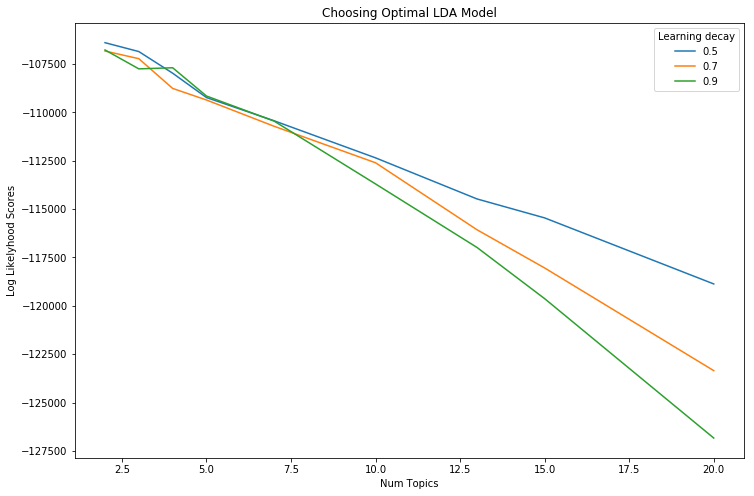

Topic #0: object visual social word doi words image neural life mind images agent org environment classification
Topic #1: robot agent dialogue speech user situation cognitive object service act robots fig interpretation objects states



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      2352.815430 -5514.87207       1        1  51.428876
0     -2352.815186  5514.87207       2        1  48.571124, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
574   Default  787.000000           robot  787.000000  30.0000  30.0000
626   Default  560.000000          speech  560.000000  29.0000  29.0000
180   Default  656.000000        dialogue  656.000000  28.0000  28.0000
609   Default  332.000000       situation  332.000000  27.0000  27.0000
598   Default  209.000000         service  209.000000  26.0000  26.0000
724   Default  239.000000            word  239.000000  25.0000  25.0000
29    Default  730.000000           agent  730.000000  24.0000  24.0000
612   Default  250.000000          social  250.000000  23.0000  23.0000
705   Default  444.000000            user  444.000000  22.0000  22.0000
725   Default  228.000000           words  228.000000  21.0000  21.0000
577   Default  200.000000          robots  200.000000  20.0000  20.0000
200   Default  257.000000             doi  257.000000  19.0000  19.0000
623   Default  157.000000   specification  157.000000  18.0000  18.0000
282   Default  115.000000           golem  115.000000  17.0000  17.0000
610   Default  167.000000      situations  167.000000  16.0000  16.0000
717   Default  485.000000          visual  485.000000  15.0000  15.0000
600   Default  140.000000            sets  140.000000  14.0000  14.0000
229   Default  140.000000    expectations  140.000000  13.0000  13.0000
340   Default  200.000000  interpretation  200.000000  12.0000  12.0000
202   Default  146.000000         domains  146.000000  11.0000  11.0000
309   Default  168.000000          images  168.000000  10.0000  10.0000
308   Default  242.000000           image  242.000000   9.0000   9.0000
250   Default  164.000000           field  164.000000   8.0000   8.0000
97    Default  156.000000  classification  156.000000   7.0000   7.0000
137   Default  105.000000  conversational  105.000000   6.0000   6.0000
713   Default  125.000000          vector  125.000000   5.0000   5.0000
227   Default  100.000000    evolutionary  100.000000   4.0000   4.0000
575   Default   97.000000         robotic   97.000000   3.0000   3.0000
726   Default  105.000000         working  105.000000   2.0000   2.0000
136   Default   98.000000    conversation   98.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
200    Topic2  224.643147             doi  257.424988   0.5859  -4.6633
77     Topic2  103.475922          camera  118.625699   0.5855  -5.4385
256    Topic2   90.962620           fixed  104.449070   0.5839  -5.5674
97     Topic2  135.884087  classification  156.092819   0.5835  -5.1660
308    Topic2  197.671283           image  242.186753   0.5190  -4.7912
286    Topic2   49.111247         greater   56.801280   0.5767  -6.1838
497    Topic2   59.060189      population   68.917307   0.5678  -5.9993
462    Topic2  141.548970             org  173.587804   0.5181  -5.1252
185    Topic2   65.352714     dimensional   76.969576   0.5585  -5.8980
580    Topic2   90.551165            role  109.158151   0.5353  -5.5719
205    Topic2   77.230717        dynamics   92.067237   0.5464  -5.7310
717    Topic2  356.522985          visual  485.280497   0.4138  -4.2014
479    Topic2  124.814948        patterns  155.295214   0.5036  -5.2510
475    Topic2   92.225768    participants  112.137767   0.5267  -5.5536
69     Topic2   99.138563            body  122.122436   0.5136  -5.4813
6      Topic2   78.528755        accuracy   94.054028   0.5417  -5.7144
448    Topic2  357.704665          object  578.395605   0.2416  -4.1981
440    Topic2  191.235983          neural  280.661219   0.3385  -4.8243
419    Topic2  177.453271            mind  255.91

In [6]:
topic_var4(path_ia, "ia")

Sparsicity:  33.82323733862959 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.9, 'n_topics': 2}
Best Log Likelihood Score:  -64326.108657058336
Model Perplexity:  355.75947409149563


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


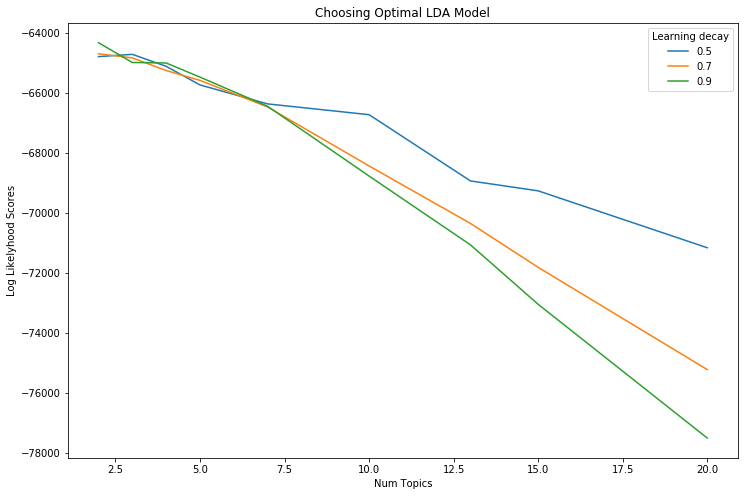

Topic #0: fuzzy delays delay flow scenario discrete distribution controller law scenarios plant neural actuator period reconfiguration
Topic #1: nodes processes parallel execution transmission sensors frequencies distance scheduling scheme tasks controller region type level



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      2352.815430 -5514.87207       1        1  56.324796
1     -2352.815186  5514.87207       2        1  43.675204, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
337   Default  553.000000         nodes  553.000000  30.0000  30.0000
199   Default  564.000000         fuzzy  564.000000  29.0000  29.0000
382   Default  278.000000     processes  278.000000  28.0000  28.0000
357   Default  238.000000      parallel  238.000000  27.0000  27.0000
116   Default  508.000000        delays  508.000000  26.0000  26.0000
165   Default  179.000000     execution  179.000000  25.0000  25.0000
115   Default  417.000000         delay  417.000000  24.0000  24.0000
189   Default  371.000000          flow  371.000000  23.0000  23.0000
138   Default  231.000000      discrete  231.000000  22.0000  22.0000
434   Default  356.000000      scenario  356.000000  21.0000  21.0000
500   Default  191.000000  transmission  191.000000  20.0000  20.0000
383   Default   91.000000     processor   91.000000  19.0000  19.0000
407   Default  100.000000        region  100.000000  18.0000  18.0000
335   Default  156.000000        neural  156.000000  17.0000  17.0000
271   Default  197.000000           law  197.000000  16.0000  16.0000
435   Default  194.000000     scenarios  194.000000  15.0000  15.0000
195   Default  159.000000   frequencies  159.000000  14.0000  14.0000
369   Default  171.000000         plant  171.000000  13.0000  13.0000
278   Default  101.000000         level  101.000000  12.0000  12.0000
215   Default   80.000000        higher   80.000000  11.0000  11.0000
139   Default  168.000000      distance  168.000000  10.0000  10.0000
438   Default  125.000000        scheme  125.000000   9.0000   9.0000
44    Default   73.000000          base   73.000000   8.0000   8.0000
311   Default   87.000000       message   87.000000   7.0000   7.0000
480   Default  129.000000         tasks  129.000000   6.0000   6.0000
446   Default  188.000000       sensors  188.000000   5.0000   5.0000
502   Default  115.000000          type  115.000000   4.0000   4.0000
462   Default   67.000000         speed   67.000000   3.0000   3.0000
105   Default   63.000000       correct   63.000000   2.0000   2.0000
16    Default   64.000000       address   64.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
311    Topic2   74.605593       message   87.842876   0.6651  -5.2086
153    Topic2   52.814943   environment   63.382048   0.6460  -5.5540
379    Topic2   29.415055      problems   35.581163   0.6381  -6.1393
283    Topic2   60.693037      location   73.753267   0.6335  -5.4150
523    Topic2   65.195884      wireless   79.440197   0.6308  -5.3434
225    Topic2   39.217037       include   47.929723   0.6278  -5.8517
182    Topic2   33.794186      features   41.324823   0.6272  -6.0006
391    Topic2   60.663913      protocol   74.709615   0.6201  -5.4155
242    Topic2   26.528971       instead   32.673680   0.6201  -6.2426
94     Topic2   54.649853    connection   68.073378   0.6087  -5.5199
392    Topic2   32.441231       provide   40.442997   0.6079  -6.0414
337    Topic2  440.323456         nodes  553.739133   0.5992  -3.4333
438    Topic2   98.633895        scheme  125.137174   0.5904  -4.9294
195    Topic2  124.275760   frequencies  159.591346   0.5783  -4.6983
455    Topic2   71.831624          size   90.835403   0.5937  -5.2465
502    Topic2   89.903224          type  115.823041   0.5751  -5.0221
480    Topic2   98.489557         tasks  129.295070   0.5562  -4.9309
139    Topic2  124.253738      distance  168.523302   0.5236  -4.6985
456    Topic2   63.806079      software   81.536219   0.5832  -5.3650
446    Topic2  130.792604       sensors  188.647730   0.4621  -4.6472
361    Topi

In [7]:
topic_var4(path_nsc, "nsc")

Sparsicity:  28.30208664336405 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.9, 'n_topics': 2}
Best Log Likelihood Score:  -23083.260571450926
Model Perplexity:  646.5689258685143


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


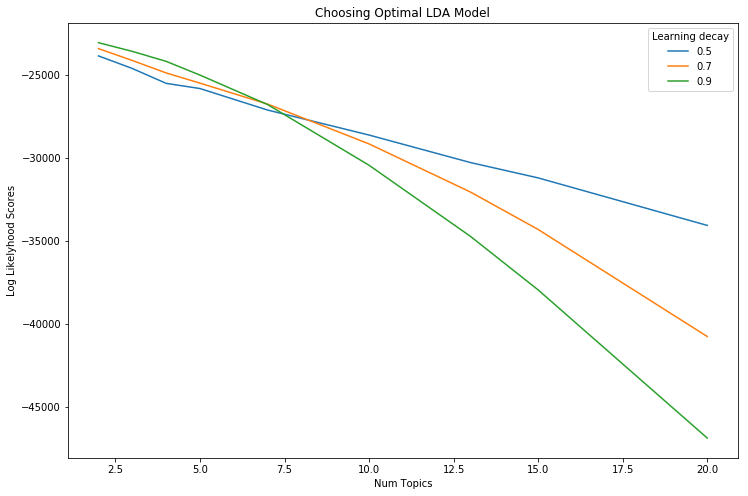

Topic #0: control quantum algebra global colors phase constrained local color group processes clusters complete search optimization
Topic #1: color image images oriented optimal herrera distance antipodal information complex radon algorithms sample matroid strausz



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      2352.815430 -5514.87207       1        1  62.962984
0     -2352.815186  5514.87207       2        1  37.037016, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
155   Default  282.000000         color  282.000000  30.0000  30.0000
219   Default   49.000000       control   49.000000  29.0000  29.0000
765   Default   38.000000       quantum   38.000000  28.0000  28.0000
463   Default  102.000000         image  102.000000  27.0000  27.0000
31    Default   30.000000       algebra   30.000000  26.0000  26.0000
702   Default   26.000000         phase   26.000000  25.0000  25.0000
206   Default   25.000000   constrained   25.000000  24.0000  24.0000
423   Default   35.000000        global   35.000000  23.0000  23.0000
744   Default   22.000000     processes   22.000000  22.0000  22.0000
151   Default   23.000000      clusters   23.000000  21.0000  21.0000
943   Default   19.000000     synthesis   19.000000  20.0000  20.0000
676   Default   44.000000      oriented   44.000000  19.0000  19.0000
435   Default   27.000000         group   27.000000  18.0000  18.0000
559   Default   31.000000         local   31.000000  17.0000  17.0000
839   Default   22.000000        search   22.000000  16.0000  16.0000
111   Default   17.000000           box   17.000000  15.0000  15.0000
174   Default   27.000000      complete   27.000000  14.0000  14.0000
78    Default   16.000000    assumption   16.000000  13.0000  13.0000
673   Default   23.000000  optimization   23.000000  12.0000  12.0000
958   Default   16.000000           tem   16.000000  11.0000  11.0000
497   Default   15.000000       initial   15.000000  10.0000  10.0000
436   Default   15.000000        groups   15.000000   9.0000   9.0000
770   Default   17.000000        random   17.000000   8.0000   8.0000
893   Default   15.000000          sons   15.000000   7.0000   7.0000
647   Default   13.000000     objective   13.000000   6.0000   6.0000
47    Default   36.000000     antipodal   36.000000   5.0000   5.0000
127   Default   14.000000       central   14.000000   4.0000   4.0000
523   Default   15.000000          john   15.000000   3.0000   3.0000
586   Default   32.000000       matroid   32.000000   2.0000   2.0000
490   Default   13.000000           inf   13.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
436    Topic2   13.521547        groups   15.253891   0.8727  -5.4693
548    Topic2    7.775277       letters    8.788370   0.8708  -6.0226
354    Topic2    9.620615           exp   10.913467   0.8672  -5.8097
958    Topic2   14.123754           tem   16.031697   0.8665  -5.4257
671    Topic2    8.323207    optimality    9.452839   0.8660  -5.9545
704    Topic2    7.103714          phys    8.068595   0.8659  -6.1129
497    Topic2   14.054953       initial   15.982406   0.8647  -5.4306
151    Topic2   20.235853      clusters   23.015553   0.8645  -5.0661
78     Topic2   14.623673    assumption   16.676396   0.8619  -5.3909
136    Topic2    6.482690        checks    7.446711   0.8546  -6.2044
127    Topic2   12.623644       central   14.513346   0.8538  -5.5380
893    Topic2   13.223186          sons   15.292025   0.8479  -5.4916
426    Topic2   11.974542      gonzalez   13.930906   0.8419  -5.5908
523    Topic2   13.044077          john   15.338087   0.8312  -5.5052
839    Topic2   18.742618        search   22.470295   0.8119  -5.1428
423    Topic2   28.660370        global   35.744904   0.7724  -4.7180
770    Topic2   14.511574        random   17.440502   0.8094  -5.3986
435    Topic2   21.347492         group   27.134682   0.7534  -5.0126
559    Topic2   23.089701         local   31.058844   0.6968  -4.9342
673    Topic2   17.988985  optimization   23.671625   0.7187  -5.1838
174    Topi

In [8]:
topic_var4(path_sc, "sc")

Sparsicity:  35.004951475539706 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.5, 'n_topics': 2}
Best Log Likelihood Score:  -107586.47572398932
Model Perplexity:  362.98603334408267


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


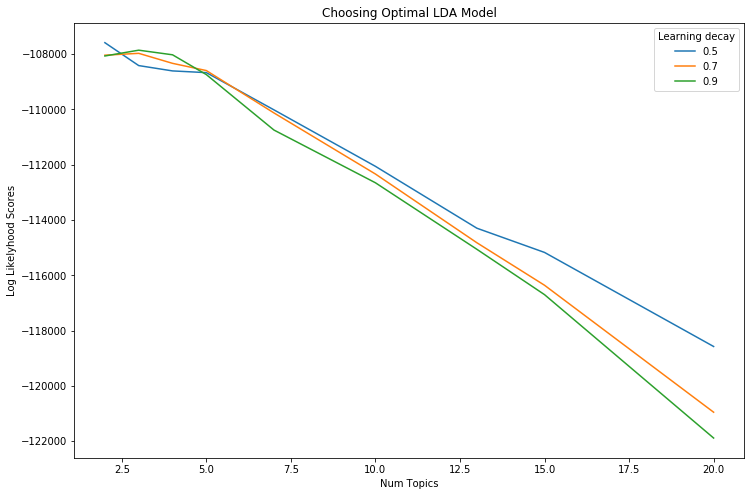

Topic #0: texture org spie coefficients matrix reconstruction volume classification filters filter area surface active gaussian patterns
Topic #1: chain curve color descriptor element line orthogonal robust robustness plane compression equal invariant surface false



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      2352.815430 -5514.87207       1        1  60.564661
1     -2352.815186  5514.87207       2        1  39.435339, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
53    Default  996.000000           chain  996.000000  30.0000  30.0000
108   Default  608.000000           curve  608.000000  29.0000  29.0000
68    Default  393.000000           color  393.000000  28.0000  28.0000
125   Default  347.000000      descriptor  347.000000  27.0000  27.0000
154   Default  266.000000         element  266.000000  26.0000  26.0000
450   Default  611.000000         texture  611.000000  25.0000  25.0000
390   Default  212.000000      robustness  212.000000  24.0000  24.0000
79    Default  201.000000     compression  201.000000  23.0000  23.0000
402   Default  175.000000        segments  175.000000  22.0000  22.0000
369   Default  336.000000  reconstruction  336.000000  21.0000  21.0000
420   Default  429.000000            spie  429.000000  20.0000  20.0000
267   Default  273.000000            line  273.000000  19.0000  19.0000
424   Default  154.000000        starting  154.000000  18.0000  18.0000
389   Default  249.000000          robust  249.000000  17.0000  17.0000
336   Default  238.000000           plane  238.000000  16.0000  16.0000
326   Default  276.000000      orthogonal  276.000000  15.0000  15.0000
158   Default  244.000000           equal  244.000000  14.0000  14.0000
486   Default  340.000000          volume  340.000000  13.0000  13.0000
7     Default  245.000000          active  245.000000  12.0000  12.0000
204   Default  201.000000       geometric  201.000000  11.0000  11.0000
209   Default  193.000000           graph  193.000000  10.0000  10.0000
282   Default  380.000000          matrix  380.000000   9.0000   9.0000
187   Default  338.000000         filters  338.000000   8.0000   8.0000
224   Default  128.000000     illustrates  128.000000   7.0000   7.0000
255   Default  272.000000       invariant  272.000000   6.0000   6.0000
67    Default  403.000000    coefficients  403.000000   5.0000   5.0000
380   Default  124.000000    representing  124.000000   4.0000   4.0000
467   Default  121.000000          unique  121.000000   3.0000   3.0000
452   Default  175.000000       threshold  175.000000   2.0000   2.0000
157   Default  168.000000          energy  168.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
205    Topic2   66.981787     geometrical   89.021667   0.6460  -5.7375
395    Topic2  102.153151         scaling  135.870200   0.6453  -5.3154
267    Topic2  205.003125            line  273.646008   0.6417  -4.6189
470    Topic2   53.706155           upper   71.844196   0.6395  -5.9584
209    Topic2  144.192791           graph  193.370085   0.6371  -4.9707
204    Topic2  149.632189       geometric  201.041755   0.6352  -4.9337
71     Topic2   86.694907        combined  116.858791   0.6319  -5.4795
317    Topic2   36.115511            open   48.923596   0.6270  -6.3552
158    Topic2  179.372355           equal  244.352717   0.6214  -4.7524
411    Topic2   78.019902      similarity  107.460733   0.6103  -5.5849
142    Topic2   81.229660      directions  112.268163   0.6069  -5.5446
326    Topic2  198.924077      orthogonal  276.313882   0.6019  -4.6490
277    Topic2   48.927801          manner   68.221653   0.5981  -6.0516
452    Topic2  125.785642       threshold  175.691475   0.5964  -5.1073
131    Topic2   67.089097        detected   94.167428   0.5915  -5.7359
15     Topic2   89.406695           angle  125.856828   0.5886  -5.4487
273    Topic2   84.507533       magnitude  120.168842   0.5785  -5.5051
462    Topic2  104.410496     translation  151.090865   0.5610  -5.2936
255    Topic2  176.704174       invariant  272.41

In [9]:
topic_var4(path_sive, "sive")

Sparsicity:  35.28769841269842 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.5, 'n_topics': 3}
Best Log Likelihood Score:  -45279.5836559897
Model Perplexity:  426.6208716211819


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


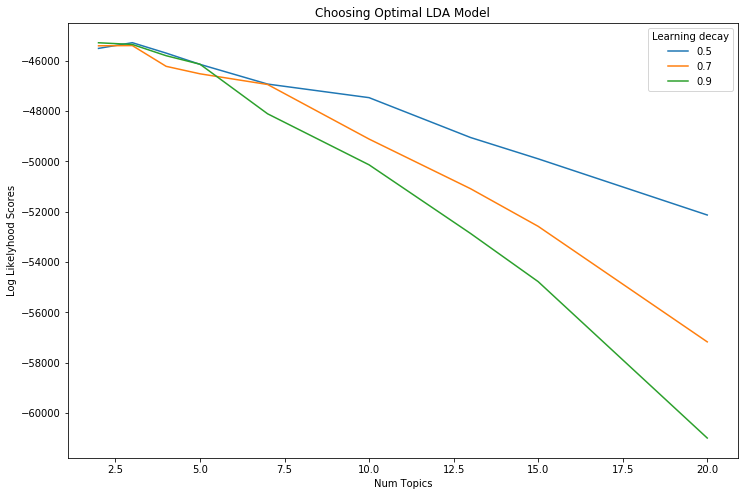

Topic #0: criteria accuracy provenance scores query derived resolution granularity consistency measurement manager aggregation metadata priorities primary
Topic #1: record records mining algorithm distance matching similarity algorithms practice false distributed multi scenario precision total
Topic #2: team relational organization let company warehouse query alternative configuration states space members study enterprise false



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -372.142456 -195.243271       1        1  36.882747
0     -437.769562 -443.703552       2        1  35.545202
2     -620.127258 -262.638367       3        1  27.572051, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
602   Default  180.000000           team  180.000000  30.0000  30.0000
496   Default  229.000000         record  229.000000  29.0000  29.0000
503   Default  136.000000     relational  136.000000  28.0000  28.0000
497   Default  209.000000        records  209.000000  27.0000  27.0000
188   Default  145.000000       distance  145.000000  26.0000  26.0000
153   Default  154.000000       criteria  154.000000  25.0000  25.0000
425   Default  123.000000   organization  123.000000  24.0000  24.0000
376   Default  147.000000       matching  147.000000  23.0000  23.0000
395   Default  160.000000         mining  160.000000  22.0000  22.0000
29    Default  156.000000      algorithm  156.000000  21.0000  21.0000
478   Default  102.000000     provenance  102.000000  20.0000  20.0000
352   Default  108.000000            let  108.000000  19.0000  19.0000
6     Default  119.000000       accuracy  119.000000  18.0000  18.0000
540   Default  104.000000         scores  104.000000  17.0000  17.0000
30    Default   93.000000     algorithms   93.000000  16.0000  16.0000
556   Default   99.000000     similarity   99.000000  15.0000  15.0000
514   Default  101.000000     resolution  101.000000  14.0000  14.0000
167   Default  103.000000        derived  103.000000  13.0000  13.0000
278   Default   97.000000    granularity   97.000000  12.0000  12.0000
106   Default   61.000000        company   61.000000  11.0000  11.0000
465   Default   63.000000     priorities   63.000000  10.0000  10.0000
24    Default   78.000000    aggregation   78.000000   9.0000   9.0000
391   Default   78.000000       metadata   78.000000   8.0000   8.0000
485   Default  150.000000          query  150.000000   7.0000   7.0000
534   Default   74.000000       scenario   74.000000   6.0000   6.0000
389   Default   51.000000        members   51.000000   5.0000   5.0000
242   Default  126.000000          false  126.000000   4.0000   4.0000
33    Default   59.000000    alternative   59.000000   3.0000   3.0000
659   Default   63.000000      warehouse   63.000000   2.0000   2.0000
577   Default   59.000000         states   59.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
313    Topic3   11.632254     increasing   14.442288   1.0720  -6.1890
337    Topic3   26.069253            iso   33.692310   1.0319  -5.3820
9      Topic3   22.854698        actions   29.660852   1.0277  -5.5136
472    Topic3   33.724733       products   43.914347   1.0244  -5.1245
426    Topic3   29.947694  organizations   39.695461   1.0066  -5.2433
642    Topic3   23.822768           uses   31.616540   1.0053  -5.4721
564    Topic3   20.676791      solutions   27.578702   1.0003  -5.6137
47     Topic3   16.508745          areas   22.412877   0.9826  -5.8388
615    Topic3   29.171124          times   39.631772   0.9819  -5.2696
270    Topic3    9.766035     generating   13.314072   0.9785  -6.3638
92     Topic3   16.359033           city   22.445774   0.9720  -5.8480
504    Topic3   19.656010   relationship   27.394930   0.9564  -5.6644
319    Topic3   24.020132       industry   33.536995   0.9546  -5.4638
209    Topic3   41.102332     enterprise   60.487196   0.9020  -4.9267
126    Topic3   50.161918  configuration   78.112253   0.8455  -4.7275
598    Topic3   28.555900         tables   42.407943   0.8929  -5.2909
589    Topic3   45.118241          study   73.030755   0.8068  -4.8334
476    Topic3   36.642897       proposal   58.129395   0.8269  -5.0415
613    Topic3   34.467690         theory   54.

In [10]:
topic_var4(path_sedb, "sedb")

Sparsicity:  35.08816983393255 %


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-package

Best Model's Params:  {'learning_decay': 0.7, 'n_topics': 2}
Best Log Likelihood Score:  -31676.575573243597
Model Perplexity:  342.8590524844967


C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\X510UR\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


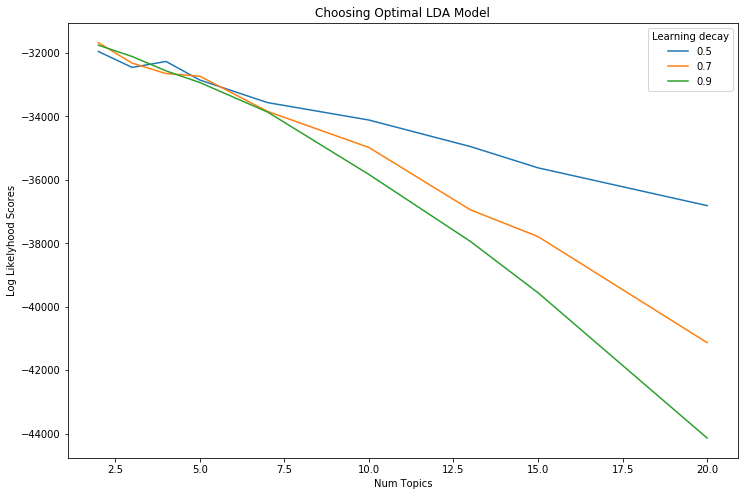

Topic #0: parallel rule http class classes designs program false logic intersection transition fig transitions models checking
Topic #1: optimal control search solutions conditions designs face average optimization mixed journal algorithms functions near graph



C:\Users\X510UR\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      2352.815430 -5514.87207       1        1  73.404099
1     -2352.815186  5514.87207       2        1  26.595901, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
331   Default  104.000000       optimal  104.000000  30.0000  30.0000
452   Default   87.000000     solutions   87.000000  29.0000  29.0000
109   Default  135.000000       control  135.000000  28.0000  28.0000
427   Default  143.000000        search  143.000000  27.0000  27.0000
98    Default  113.000000    conditions  113.000000  26.0000  26.0000
183   Default   59.000000          face   59.000000  25.0000  25.0000
332   Default   54.000000  optimization   54.000000  24.0000  24.0000
303   Default   48.000000         mixed   48.000000  23.0000  23.0000
198   Default   50.000000     functions   50.000000  22.0000  22.0000
14    Default   53.000000    algorithms   53.000000  21.0000  21.0000
256   Default   60.000000       journal   60.000000  20.0000  20.0000
37    Default  100.000000       average  100.000000  19.0000  19.0000
318   Default   35.000000          near   35.000000  18.0000  18.0000
43    Default   37.000000          best   37.000000  17.0000  17.0000
247   Default   38.000000       integer   38.000000  16.0000  16.0000
486   Default   36.000000     technique   36.000000  15.0000  15.0000
208   Default   49.000000         graph   49.000000  14.0000  14.0000
220   Default  209.000000          http  209.000000  13.0000  13.0000
136   Default   37.000000    difference   37.000000  12.0000  12.0000
344   Default   36.000000      positive   36.000000  11.0000  11.0000
268   Default   36.000000         lemma   36.000000  10.0000  10.0000
101   Default   29.000000     connected   29.000000   9.0000   9.0000
130   Default  216.000000       designs  216.000000   8.0000   8.0000
418   Default  240.000000          rule  240.000000   7.0000   7.0000
292   Default   49.000000        matrix   49.000000   6.0000   6.0000
152   Default   25.000000          edge   25.000000   5.0000   5.0000
105   Default   23.000000  constructing   23.000000   4.0000   4.0000
335   Default  304.000000      parallel  304.000000   3.0000   3.0000
376   Default   37.000000        random   37.000000   2.0000   2.0000
0     Default   25.000000     according   25.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
105    Topic2   18.205325  constructing   23.291079   1.0781  -5.3470
344    Topic2   28.162852      positive   36.416247   1.0674  -4.9108
268    Topic2   28.073301         lemma   36.479508   1.0625  -4.9139
122    Topic2   17.114146        degree   22.252318   1.0619  -5.4089
136    Topic2   28.441791    difference   37.450695   1.0492  -4.9009
40     Topic2    8.108733     beginning   10.871114   1.0312  -6.1558
49     Topic2   15.647100         bound   21.313154   1.0154  -5.4985
79     Topic2   13.968129  combinations   19.492523   0.9912  -5.6120
97     Topic2   15.203621   conclusions   21.321267   0.9862  -5.5272
256    Topic2   42.876238       journal   60.154005   0.9858  -4.4904
113    Topic2   13.766481          cost   19.419748   0.9804  -5.6265
184    Topic2   10.420362         faces   14.730079   0.9783  -5.9050
0      Topic2   17.724355     according   25.110158   0.9761  -5.3738
255    Topic2   12.369830          issn   17.558961   0.9741  -5.7335
304    Topic2   16.792929           mod   24.178669   0.9599  -5.4278
493    Topic2   13.471617         tions   19.420689   0.9587  -5.6482
208    Topic2   32.073196         graph   49.801038   0.8844  -4.7807
109    Topic2   77.222802       control  135.152878   0.7647  -3.9021
98     Topic2   63.921766    conditions  113.292307   0.7521  -4.0911
512    Topic2   17.532004        vector   26.078586   0.9273  -5.3847
427    Topi

In [11]:
topic_var4(path_tc, "tc")

# Longitud promedio

In [42]:
def long_prom(path, folder):
    txt = read_txt_files(glob(path + folder + '*.txt'))
    AfterMeanCharacters = pd.Series(txt).str.len().mean()
    AfterMeanWords = pd.Series(txt).apply(lambda x: len(str(x).split(" "))).mean()
    lista = []
    
    for text in txt:
        t = text_clean(str(text))
        lista.append(t)
    BeforeMeanCharacters = pd.Series(lista).str.len().mean()
    BeforeMeanWords = pd.Series(lista).apply(lambda x: len(str(x).split(" "))).mean()
    
    print('Characters: ', (AfterMeanCharacters, BeforeMeanCharacters))
    print('Words: ', (AfterMeanWords, BeforeMeanWords))
    return

In [56]:
#folder = 'text/' 
#folder = 'abstract/'
folder = 'keywords/'
long_prom(path_ia, folder)

Characters:  (84.98076923076923, 83.1923076923077)
Words:  (9.326923076923077, 9.557692307692308)


In [57]:
long_prom(path_nsc, folder)

Characters:  (76.2280701754386, 76.43859649122807)
Words:  (8.43859649122807, 8.824561403508772)


In [58]:
long_prom(path_sc, folder)

Characters:  (84.22222222222223, 83.22222222222223)
Words:  (9.444444444444445, 10.0)


In [59]:
long_prom(path_sive, folder)

Characters:  (92.40196078431373, 91.29411764705883)
Words:  (10.362745098039216, 10.627450980392156)


In [60]:
long_prom(path_sedb, folder)

Characters:  (74.63333333333334, 72.56666666666666)
Words:  (8.3, 8.666666666666666)


In [61]:
long_prom(path_tc, folder)

Characters:  (92.04545454545455, 89.63636363636364)
Words:  (9.818181818181818, 9.954545454545455)
